# VaultProtect

## Description

Face recognition machine learning model creation and training for unlocking a secure data vault.

- Base model: [VGG-16](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16).
- Datasets: [DigiFace-1M](https://github.com/microsoft/DigiFace1M).

It has also been tested with a variety of base models (VGG-19, ResNet50, ResNet152) and datasets (FLW, custom faces), but the best results seems to resulted from VGG-16 and DigiFace-1M.

## Setup

Tested with Tensorflow `1.25.0` and Python `3.11.6`.

### On all platforms

In [ ]:
!pip install tensorflow pillow scikit-learn matplotlib

### On macOS (to use the GPU)

In [ ]:
!pip install tensorflow-macos tensorflow-metal

## Code

In [10]:
import os
import datetime
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
# noinspection PyUnresolvedReferences
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
# noinspection PyUnresolvedReferences
from tensorflow.python.keras.regularizers import l2
from matplotlib import pyplot as plt

The values below defines the different data locations:

- `train_dir`: The directory containing the training data.
- `validation_dir`: The directory containing the validation data (to influence the weights improvements upon training).
- `test_dir`: The directory containing the test data (that has never been used by the training or validation of the model).
- The expected size of the images.
- The batch size for model training.
- The number of epochs for model training.
- The number of classes (= people) in the training dataset.

In [11]:
train_dir = "datasets/train"
validation_dir = "datasets/validation"
test_dir = "datasets/test"
model_path = "models/vaultprotect.keras"
img_width = 224
img_height = 224
batch_size = 32
epochs = 5
num_people = len([f for f in os.listdir(train_dir) if not f.startswith(".")])

Change the value below:
- `load` to load the model if it already has been trained and saved.
- `save` to save the model after training.
- `train` to train the model.
- `test` to test the model.

In [12]:
load = False
save = False
train = True
test = True

## Creation of the model

We use the VGG-16 model as a base model, and we add a few layers on top of it to adapt it to our needs.

The base model is not trained, only the layers we add on top of it are trained. As VGG-16 is already supposed to be a well-trained model, we prefer to not influence its weights as it would add overall complexity when evaluating the results from our point of view.

The layers we add on top of the base model are:

- A `Flatten` layer to flatten the output of the base model.
- A `Dense` layer with 1024 neurons and a `relu` activation function.
- A `Dropout` layer with a `0.5` rate.
- A `Dense` layer with the number of classes (= people) as neurons and a `softmax` activation function.

Then, we load the weights of the model if it has already been trained and saved.

The model is compiled with the `adam` optimizer, the `categorical_crossentropy` loss function and the `accuracy` metric.

In [13]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(img_width, img_height, 3))

for layer in base_model.layers:
    layer.trainable = False

base_model_output = Flatten()(base_model.output)

base_model_output = Dense(1024, activation='relu')(base_model_output)
base_model_output = BatchNormalization()(base_model_output)
base_model_output = Dropout(0.5)(base_model_output)

base_model_output = Dense(1024, activation='relu')(base_model_output)
base_model_output = BatchNormalization()(base_model_output)
base_model_output = Dropout(0.5)(base_model_output)

base_model_output = Dense(num_people, activation='softmax')(base_model_output)

model = Model(inputs=base_model.input, outputs=base_model_output)

if load and os.path.exists(model_path):
    model.load_weights(model_path)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

## Training of the model

For the training dataset, we use the `ImageDataGenerator` class to generate batches of tensor image data with real-time data augmentation.

For the validation, we use the `ImageDataGenerator` class to generate batches of tensor image data without data augmentation because it needs to be as close as the original data as possible.

We define the `ModelCheckpoint` callback to save the model with the best weights during the training.

We define the `EarlyStopping` callback to stop the training if the validation loss does not improve after 50 epochs.

Then, we train the model with the `fit` method.

Finally, we save the model weights.

Found 10600 images belonging to 200 classes.
Found 2800 images belonging to 200 classes.
2024-01-29 08:42:35.709041
Epoch 1/5
331/331 [==============================] - 92s 277ms/step - loss: 3.6085 - accuracy: 0.2227 - val_loss: 2.1924 - val_accuracy: 0.4767
Epoch 2/5
331/331 [==============================] - 93s 280ms/step - loss: 2.7699 - accuracy: 0.3512 - val_loss: 1.8311 - val_accuracy: 0.5474
Epoch 3/5
331/331 [==============================] - 91s 273ms/step - loss: 2.3366 - accuracy: 0.4332 - val_loss: 1.5170 - val_accuracy: 0.6210
Epoch 4/5
331/331 [==============================] - 91s 275ms/step - loss: 2.0128 - accuracy: 0.4989 - val_loss: 1.3105 - val_accuracy: 0.6534
Epoch 5/5
331/331 [==============================] - 91s 275ms/step - loss: 1.8362 - accuracy: 0.5339 - val_loss: 1.2035 - val_accuracy: 0.6800
2024-01-29 08:50:13.688888
[0.22265329957008362, 0.3511544167995453, 0.4331945478916168, 0.4988645017147064, 0.5338758230209351] [0.4766522943973541, 0.547413766384

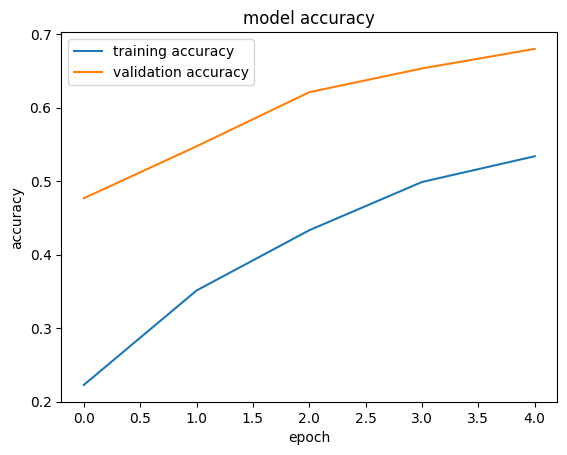

[3.6085174083709717, 2.769864320755005, 2.3366024494171143, 2.0128066539764404, 1.8361856937408447] [2.1924309730529785, 1.8311318159103394, 1.5169596672058105, 1.3105335235595703, 1.2034512758255005]


<Figure size 640x480 with 0 Axes>

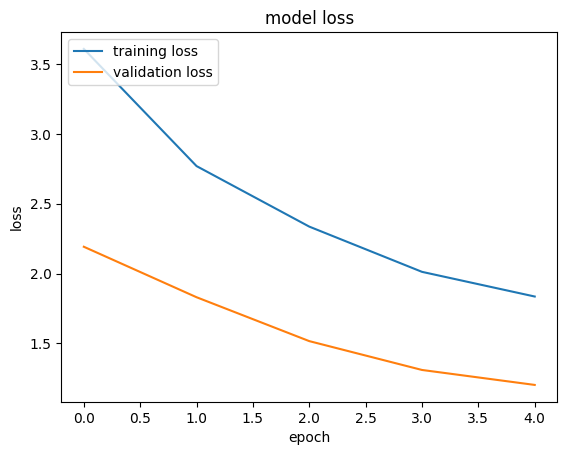

In [16]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical")

if train:
    val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode="categorical")

    #tl_checkpoint_1 = ModelCheckpoint(filepath=model_path.replace(".keras", ".checkpoint.keras"),
    #                                  save_best_only=True,
    #                                  verbose=1)

    #early_stop = EarlyStopping(monitor="val_loss",
    #                           patience=50,
    #                           restore_best_weights=True,
    #                           mode="min")

    print(datetime.datetime.now())

    history = model.fit(train_generator,
              steps_per_epoch=train_generator.samples // batch_size,
              epochs=epochs,
              validation_data=validation_generator,
              validation_steps=validation_generator.samples // batch_size,
              #callbacks=[tl_checkpoint_1, early_stop])
    )

    print(datetime.datetime.now())

    if save:
        model.save_weights(model_path)

    accuracy_stats = plt.figure()
    print(history.history['accuracy'], history.history['val_accuracy'])
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training accuracy', 'validation accuracy'], loc='upper left')
    plt.show()
    # accuracy_stats.savefig("accuracy_stats.pdf")

    plt.clf()

    loss_stats = plt.figure()
    print(history.history['loss'], history.history['val_loss'])
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training loss', 'validation loss'], loc='upper left')
    plt.show()
    # loss_stats.savefig("loss_stats.pdf")

## Evaluation of the model

We use the `ImageDataGenerator` class to generate batches of tensor image data without data augmentation because it needs to be as close as the original data as possible.

Then, we evaluate the model with the `evaluate` method.

Finally, we print the test accuracy.

In [9]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical")

test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)

print("Test accuracy:", test_acc)

Found 1000 images belonging to 200 classes.
31/31 [==============================] - 7s 211ms/step - loss: 0.2553 - accuracy: 0.9294
Test accuracy: 0.9294354915618896
